# ADM-HW4

## 1. Hashing task!

The first step to take is to create the class for the **BloomFilter**.  

The Bloom filter has to take in input the *number of total items* that will be added to it and the *false-positive probability* desired.  
Given this 2 variables as input, the filter has to automatically calculate the length needed for the array and the number of hash functions needed to achieve the requested FP-prob.  

The BloomFilter is also resposible for *adding* new items and for *checking* if some items are already added to it. For completing this tasks we also need to define a hash function which, given an item, returns the position of the array that has to be turned from 0 to 1. Given the fact that we could need more than 1 hash function, the one actually defined depends on a seed, so if we give in input the same item, but with a different seed, the function returns a different integer.

The hash function used is based on the **DJB2-H method**, introduced by Daniel J. Bernstein.  
The concept is pretty simple:  
1. start with a hash_code equal to 0  
2. for each character in the string take its ASCII integer value and sum it to the hash_code multiplied by a prime number. The prime number used in this case is 31 since it has been proved to produce optimal results.  
3. since we want a family of k hash functions, multiply the ASCII value by a seed, depending on the number of the hash function utilized at the moment.

Before usinge the *DJB2-H* method we tried with the *multiplication method* but the results obtained were far less optimal.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from threading import Thread
import time

In [2]:
class BloomFilter(object):
     
    def __init__(self, n_items, fp_prob, hash_count = 0):
        self.fp_prob = fp_prob
        self.n_items = n_items
        self.array_len = self.get_array_len(self.n_items, self.fp_prob)
        self.hash_count = hash_count
        if hash_count == 0:
            self.hash_count = self.get_hash_count(self.n_items, self.array_len)
        self.array = np.zeros(self.array_len)

    def get_array_len(self, n, p):
        m = -(n*math.log(p))/(math.log(2)**2)
        return int(m)

    def get_hash_count(self, n, m):
        k = (m/n)*math.log(2)
        return int(k)

    def hash(self, s, seed):
        g = 31
        res = 1

        for c in s:
            res = g*res + ord(c)*seed

        return (res % self.array_len)

    def add(self, item):
        for i in range(1, self.hash_count + 1):
            index = self.hash(item, i)
            self.array[index] = 1

    def exists(self, item):
        for i in range(1, self.hash_count + 1):
            index = self.hash(item, i)
            if self.array[index] == 0:
                return False
        return True

    def describe(self):
        print("False-positive probability (%): ", self.fp_prob*100)
        print("Number of items: ", self.n_items)
        print("Array length: ", self.array_len)
        print("Number of hash functions: ", self.hash_count)

Now we are going to demostrate that the hash function generates integers with a normal distribution over the total array length. We will use just 100k passwords for this simulation.

In [3]:
passwords1_path = "data\passwords\passwords1.txt"
passwords2_path = "data\passwords\passwords2.txt"

In [4]:
with open(passwords1_path, 'r') as f:
    passwords1 = f.read().splitlines()
passwords1[:5]

['JV#0$S;D@j+c96/8C(W%',
 "J,)e+LH'ENmdV5YGWu4B",
 'tR0V2@$SNuU9;<&DafxO',
 '/DXhI;GNl*nbCzKso=?@',
 'b*ZB/egd=!XcvV>K(qY@']

In [5]:
n = 100000
BF = BloomFilter(n, 0.001)
m = BF.array_len
k = BF.hash_count

In [6]:
print(m)
print(k)

1437758
9


In [6]:
ls_hash = []
for pwd in passwords1[:n]:
    for i in range(1, k+1):
        ls_hash.append(BF.hash(pwd, i))

Here are some results:

In [7]:
hash_series = pd.Series(ls_hash)
hash_series.describe()

count    1.000000e+06
mean     7.188063e+05
std      4.151830e+05
min      0.000000e+00
25%      3.591618e+05
50%      7.188230e+05
75%      1.078158e+06
max      1.437750e+06
dtype: float64

First of all we can see that all of the integers generated are in the range from 0 to m

In [8]:
print("hash_series out of range: ", hash_series.max() > m or hash_series.min() < 0)

hash_series out of range:  False


Now we will plot the distribution of the integers to demonstrate that it is uniform

(array([20245., 20147., 20049., 20076., 19901., 20040., 19804., 19891.,
        19936., 19900., 20086., 20161., 19890., 20016., 19859., 19794.,
        19989., 20284., 19955., 19948., 20154., 19944., 19852., 20023.,
        20094., 19906., 20168., 19936., 19813., 19865., 20253., 19696.,
        19973., 20254., 20073., 19943., 20200., 19847., 19946., 19978.,
        19997., 20177., 19947., 20109., 19867., 20143., 19957., 20010.,
        19624., 20280.]),
 array([      0.,   28755.,   57510.,   86265.,  115020.,  143775.,
         172530.,  201285.,  230040.,  258795.,  287550.,  316305.,
         345060.,  373815.,  402570.,  431325.,  460080.,  488835.,
         517590.,  546345.,  575100.,  603855.,  632610.,  661365.,
         690120.,  718875.,  747630.,  776385.,  805140.,  833895.,
         862650.,  891405.,  920160.,  948915.,  977670., 1006425.,
        1035180., 1063935., 1092690., 1121445., 1150200., 1178955.,
        1207710., 1236465., 1265220., 1293975., 1322730., 1351485.

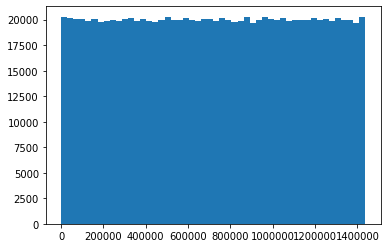

In [9]:
plt.hist(ls_hash, bins = 50)

### Bloom Filter Check

In [7]:
with open(passwords2_path, 'r') as f:
    passwords2 = f.read().splitlines()
passwords2[:5]

[')cKy&3MG+V?J@Ps=,p0k',
 'PHxf(Xu/eWTtIR;-,<bd',
 'oZs,l!:b4LqHC#y"S.?m',
 'C+sTrO#>6Gw"RmlWboAi',
 'MK!<6d4g2icTLHkD9W1R']

This is the number of passwords that we will add to the BloomFilter

In [8]:
n = len(passwords1)
n

100000000

And this the number of password to check

In [9]:
len(passwords2)

39000000

In this case we will create a Bloom Filter with FP-prob equal to 0.1%.

In [11]:
BF = BloomFilter(n, 0.00001, 11)
BF.describe()

False-positive probability (%):  0.001
Number of items:  100000000
Array length:  2396264594
Number of hash functions:  11


Now we can add the passwords to the filter. We will also calculate the time needed for the process to complete.

In [19]:
import time

In [20]:
def exec_bloom_filter(BF, passwords1, passwords2):
    start = time.time()
    
    i = 0
    for pwd in passwords1:
        BF.add(pwd)
        if (i%100000) == 0:
            print(i)
        i += 1

    duplicates = []
    i = 0
    for pwd in passwords2:
        if BF.exists(pwd):
            duplicates.append(pwd)
        if (i%100000) == 0:
            print(i)
        i += 1
        
    end = time.time()
    return (duplicates, int(end-start))

The previous **exec_bloom_filter** is also going to save the array in a txt file since it could be useful in the future if we want to check new passwords without having to re-add the passwords from *passwords1* to the filter.

### Running the test on the whole dataset

In [ ]:
(duplicates, seconds) = exec_bloom_filter(BF, passwords1, passwords2)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

In [ ]:
print('\nNumber of hash function used: ', BF.hash_count) 
print('Number of duplicates detected: ', len(duplicates)) 
print('Probability of false positives: (%)', BF.fp_prob*100) 
print('Execution time: ', seconds, ' seconds')

This is the results obtained:  
- **Number of hash functions used:** 9
- **Number of duplicates detected:** 16217499
- **Probability of false positives (%):** 0.1
- **Execution time:** 4806 seconds -> about 1 hour and 20 minutes

In [ ]:
with open('duplicates.txt', 'w') as f:
    for pwd in duplicates:
        f.write("%s\n" % pwd)

### Multithread implementation for faster execution

In the next sections I'm going to implement the execution on the Bloom filter in multithread, both for adding passwords to the filter and for checking the presence of duplicates.

In [4]:
def add(BF, passwords):
    i = 0
    for pwd in passwords:
        BF.add(pwd)
        if (i%100000) == 0:
            print(i)
        i += 1

In [5]:
def check(BF, passwords, duplicates):
    i = 0
    for pwd in passwords:
        if BF.exists(pwd):
            duplicates += 1
        if (i%100000) == 0:
            print(i)
        i += 1

In [6]:
def multithread_add(BF, passwords, n_threads):
    N = len(passwords)
    l_chunks = N // n_threads
    chunks = [passwords[i:i + l_chunks] for i in range(0, N, l_chunks)]

    if len(chunks) > n_threads:
        chunks[-2] += chunks[-1]
        del chunks[-1]

    threads = []

    for i in range(n_threads):
        threads.append(
            Thread(name='Thread-' + str(i),
            target=add, args=[BF, chunks[i]])
        )

    # start each thread
    for t in threads:
        t.start()

    # wait for each thread to finish its execution
    for t in threads:
        t.join()

In [7]:
def multithread_check(BF, passwords, n_threads):
    N = len(passwords)
    l_chunks = N // n_threads
    chunks = [passwords[i:i + l_chunks] for i in range(0, N, l_chunks)]

    if len(chunks) > n_threads:
        chunks[-2] += chunks[-1]
        del chunks[-1]

    threads = []
    partial_duplicates = [0 for i in range(n_threads)]

    for i in range(n_threads):
        threads.append(
            Thread(name='Thread-' + str(i),
            target=check, args=[BF, chunks[i], partial_duplicates[i]])
        )

    # start each thread
    for t in threads:
        t.start()

    # wait for each thread to finish its execution
    for t in threads:
        t.join()

    duplicates = 0
    for d in partial_duplicates:
        duplicates += d

    return duplicates

In [8]:
def multithread_exec_filter(BF, passwords1, passwords2_path, n_threads):
    start = time.time()

    print("Adding passwords from Passwords1 to the filter")
    multithread_add(BF, passwords1, n_threads)
    passwords1 = None
    print("Password1 added")
    
    print("Reading passwords from passwords2.txt")
    with open(passwords2_path, 'r') as f:
        passwords2 = f.read().splitlines()
    print("Checking existing passwords from Password2")
    duplicates = multithread_check(BF, passwords2, n_threads)

    end = time.time()
    print("FINISHED")
    
    return (duplicates, int(end-start))

In [9]:
with open(passwords1_path, 'r') as f:
    passwords1 = f.read().splitlines()

In [10]:
print("Initializing Bloom filter\n")
n = len(passwords1)
BF = BloomFilter(n, 0.00001, 11)
BF.describe()
print('\n')

Initializing Bloom filter

False-positive probability (%):  0.001
Number of items:  100000000
Array length:  2396264594
Number of hash functions:  11




In [ ]:
(duplicates, seconds) = multithread_exec_filter(BF, passwords1, passwords2_path, 9)

Adding passwords from Passwords1 to the filter
0
0
0
0
0
0
0
0
0
100000
100000
100000
100000
100000
100000
100000100000

100000
200000
300000
200000
200000
200000
200000
200000
200000
200000
200000
400000
300000
500000
300000
300000
300000
300000
300000
300000
300000
600000
400000
400000
700000
400000
400000
400000
400000
400000
400000
800000
500000
500000
500000
900000
500000
500000
500000
500000
500000
1000000
600000
600000
600000
1100000
600000
600000
600000
600000
600000
1200000
700000
700000
700000
1300000
700000
700000
700000
700000
700000
1400000
800000
800000
800000
1500000
800000
800000
800000
800000
800000
1600000
900000
900000
900000
1700000
900000
900000
900000
900000
1800000
1000000900000

1000000
1000000
1900000
1000000
1000000
1000000
1000000
1100000
2000000
1000000
1100000
1100000
2100000
1100000
1100000
1100000
1200000
1100000
2200000
1200000
1100000
1200000
2300000
1200000
1200000
1200000
1300000
2400000
1300000
1200000
1300000
1200000
2500000
1300000
1300000
1400000


In [ ]:
print('\nNumber of hash function used: ', BF.hash_count) 
print('Number of duplicates detected: ', duplicates) 
print('Probability of false positives: (%)', BF.fp_prob*100) 
print('Execution time: ', seconds, ' seconds')

#### Some other stats

In [155]:
def count_equals(passwords1, passwords2):
    count = 0
    for p in passwords2:
        if p in passwords1:
            count += 1
    return count

In [67]:
test_pwd1 = passwords1[100000:300000]
test_pwd2 = passwords2[:30000]
BF = BloomFilter(len(test_pwd1), 0.001)
BF.describe()

False-positive probability (%):  0.1
Number of items:  200000
Array length:  2875517
Number of hash functions needed:  10


In [68]:
duplicates = exec_bloom_filter(BF, test_pwd1, test_pwd2)

Number of hash function used:  10
Number of duplicates detected:  1146
Probability of false positives: (%) 0.1
Execution time:  7  seconds


In [259]:
# total equals = 
CE = count_equals(test_pwd1, test_pwd2)

In [264]:
TN = len(test_pwd2) - CE
FP = duplicates - CE
FPR = FP / (FP + TN)
FPR*100

2.6281550871714807

## 2. Alphabetical Sort

In this section are contained the discussions regarding time complexity about the functions created for the resolution of the exercise.

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

### Counting sort

**Counting sort** assumes that every int in the input, list with length *n*, is in the range *0 <= k <= n*. With this constraing we can assume that O(k) lies under O(n).

In [22]:
def counting_sort(A):
    """
    This function takes in input a list of integers and return a new ordered list, based on the first one.
    :param A: the list to order
    :type A: list of int
    :return: ordered list
    :rtype: list of int
    """
    k = max(A)  # O(n)
    n = len(A)  # O(1)
    B = [0 for i in range(n)]  # O(n)
    C = [0 for i in range(k+1)]  # O(k) -> O(n)

    for i in range(n):  # O(n)
        C[A[i]] += 1  # O(1)
        # each element C[i] is equal to the number of i in the array A

    for i in range(1, k+1):  # O(k) -> O(n)
        C[i] += C[i-1]  # O(1)
        # each C[i] is now equal to the number of elements in A equal or less than i

    for i in range(n-1, -1, -1):  # O(n)
        el = A[i]  # O(1)
        index = C[el]-1  # O(1)
        B[index] = el  # O(1)  # insert A[i] in the right position in B, given by C[i]-1
        C[el] += -1  # O(1)  # decrease by one the number of elements equal or less than A[i]

    return B

After analyzing the **counting_sort** function it is easy to calculate its time complexity, since it corresponds to a sum of complexities not bigger than **_O(n)_**. So, assuming O(k) = Theta(n), the total time complexity of the algorithm is **_O(n)_**.

Just in the case of *k* being bigger than *n*, then the complexity would be **O(k)**.

Given the counting_sort function it's easy to define a new function for ordering a list of char.

In [23]:
def char_couting_sort(lst):
    """
    This function takes in input a list of char and returns a new list, based on the first
    one but ordered alphabetically.
    :param lst: list of char
    :return: ordered list of char
    """
    A = [(ord(c)-diff) for c in lst]  # convert each char into an integer and put it into a list
    B = counting_sort(A)  # order the list
    return [chr(x+diff) for x in B]  # convert the integers into chars and return the list

The idea behing it is that each char in the english alphabet has a corresponding ASCII code. So we can convert the chars into integers, normalize them so that the first char has value 1, and order the list using the counting sort.

### Strings counting sort

To be able to order alphabetically a list of strings, we need to define to define 2 new different functions:  
1. An **imperative function** which orders a list of strings alphabetically based on the position of an internal character and, at the end, groups the strings by their char in position j and returns the new list of lists.  
2. A **recursive function** which launch the counting sort function over sublists of the initial list and, at the end, return a single list containing all the strings ordered alphabetically.


Let's define the imperative one and calculate it's complexity. It's important to specify that this function is just a minor variation of the counting sort function which orders lists of strings.

In [24]:
def strings_counting_sort(A, j):
    """
    This function takes in input a list and an integer j, 
    which is the index based on which the functions has to order the list of strings.
    It returns a list of lists. Each list has the strings grouped by the j_th item.
    :param A: list of strings to order
    :return: list of lists, ordered by the j_th item
    """
    diff = ord('A') - 1
    k = ord('z') - ord('A') + 1  # O(1)  # number of possible chars at position j
    n = len(A)  # O(1)
    C = [0 for i in range(k+1)]  # O(k)  # list to store the number of strings with the same char in position j
    to_return = []  # this list will store the strings whose length is equal or smaller than j

    for i in range(n):  # O(n)  # loop over the list of strings
        if len(A[i]) <= j:  # O(1)  # if the string doesn't have the j_th item, 
            # put the string in the to_return list and go directly to the next string.
            to_return.append(A[i])  # O(1)
            continue

        if A[i][j] == ' ':  # O(1)  # the *space* has index 0 (arbitrary choice)
            index = 0  # O(1)
        else:
            index = ord(A[i][j])-diff  # O(1)
            # the value in position *index* in C will be the number of strings containing
            # the same char in position j. (e.g. if j==3 and A[i][j] = 'a' then index = ord('a') = 1)
        C[index] += 1  # O(1)
        # each element C[i] is equal to the number of i in the array A

    # now remove from the list A the strings already ordered which are contained in to_return
    for word in to_return:  # O(n) # generally it is smaller than n
        A.remove(word)  # O(n) # this operation of removing take the total complexity of the algo to O(n^2)

    for i in range(1, k+1): # O(k)
        C[i] += C[i-1]  # O(1)
        # each C[i] is now equal to the number of elements in A equal or less than i

    n = len(A)  # re-calculate len(A) since there have been removed some strings
    B = [0 for i in range(n)]  # O(n)
    for i in range(n-1, -1, -1):  # O(n)
        char = ord(A[i][j])-diff  # O(1)
        if A[i][j] == ' ':  # O(1)  # the *space* has index 0 (arbitrary choice)
            char = 0  # O(1)
        index = C[char]-1  # O(1)
        B[index] = A[i]  # O(1) # insert A[i] in the right position in B, given by C[i]-1
        C[char] += -1  # O(1)  # decrease by one the number of elements equal or less than A[i]

    # since the list will be returned to the recursive function, it needs to be a list of lists
    # where each list contain the strings with the same char in position j
    grouped_list = my_groupby(B, j)  # O(n)
    if len(to_return) > 0:  # if it is not empty, insert at the head of the grouped_list the list to_return
        grouped_list.insert(0, to_return)  # O(1)
    return grouped_list

To use the previous function we also need to define a groupby function, which has complexity *O(n)*:

In [25]:
def my_groupby(lst, i):
    """
    This function takes in input a list and an index, groups its items based on the index and
    returns the list grouped.
    :param lst: list to group
    :param i: char position to group the items
    :return: grouped list
    """
    d = {}
    for x in lst:
        d.setdefault(x[i], []).append(x)
    return list(d.values())

So, the time complexity of the **strings_counting_sort** function is not anymore the same as a normal counting_sort. Given the fact that we have to order strings, which are more complex objects than integers, the complexity goes from **_O(n)_** to **_O(n^2)_**.  
In particular, it is the section of code where we remove the already ordered strings that takes **O(n^2)** time. And, given the fact that the complexity is given by the sum of O(n), O(1), O(k) and O(n^2) complexities, we obtain a **final running time of _O(n^2)_**.  
It is also important to consider that most of the times the strings to remove will be far less than the total number of strings *n*, so in this case the complexity is practically way lower than *O(n)*.

### Recursive alphabetical sort

The following is the recursive function which will take the grouped list of list returned by the *strings_counting_sort* and recurr over each of those list.  
The code of the function is pretty simple.  
First it checks if the list ha len 1 or if all the strings in it are equal.  
Then it sorts the list that has been passed to it.  
And, finally, it recurs over each sublist obtained by the sorting function to obtain all sorted lists, which will be merged at the end to form a single sorted list of strings.

In [26]:
def rec_alphabetical_sort(lst, j):
    """
    This is a recursive function which takes in input a list of strings
    and an integer and returns the sorted list.
    :param lst: list of strings to sort
    :param j: integer
    :return: sorted list of strings
    """
    if len(set(lst))<=1:  # O(n), depends on the lenght of lst
        # if the list contains one or less strings, or the strings are all equal
        return lst

    # sort the list using the imperative function.
    # the list will be sorted based on the j_th char of each string.
    sorted_lst = strings_counting_sort(lst, j)  # O(n^2), as we have already seen
    # the list returned is a grouped list where each list
    # contains string with the same prefix until the j_th char.

    # now the function will recurr over each group of strings (sublist)
    # and will append each result to a final list, which will contain
    # grouped lists.
    j += 1
    final = []
    for l in sorted_lst:
        final.append(rec_alphabetical_sort(l, j))
    
    # flatten the list of lists and return it
    return [word for sublist in final for word in sublist]

In [27]:
import random
import string
''.join(random.choices(string.ascii_letters, k=6))

'XGzVQr'

In [34]:
lists_list = []

for j in range(22):
    lst = []
    for i in range(2**j):
        lst.append(''.join(random.choices(string.ascii_letters + ' ', k=random.randint(1, 50))))
    lists_list.append(lst)

lens = []
for lst in lists_list:
    lens.append(len(lst))
    
print(*lens)

1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152


In [35]:
import time

times = []
for lst in lists_list:
    start = time.time()
    rec_alphabetical_sort(lst, 0)
    times.append(time.time() - start)

print(times)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000997304916381836, 0.0019915103912353516, 0.0019533634185791016, 0.004493236541748047, 0.011484384536743164, 0.030962467193603516, 0.06685423851013184, 0.09874463081359863, 0.1757349967956543, 0.3837873935699463, 0.929889440536499, 2.1969804763793945, 4.875424861907959, 10.908299922943115, 30.090034246444702]


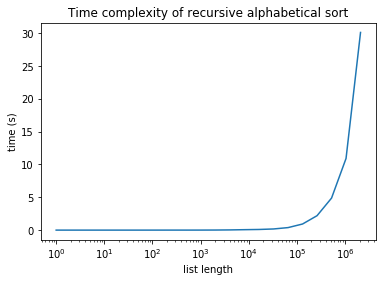

In [36]:
fig, ax = plt.subplots()
ax.plot(lens, times)
ax.set(ylabel='time (s)', xlabel='list length',
       title='Time complexity of recursive alphabetical sort',
      xscale = 'log')
plt.show()